# Physical attacks - Detection

## I - Modules

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score,recall_score,ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np


## II - Charger donnée

Utilisons donnée préparée :

In [2]:
df_normal = pd.read_csv("preparation/physical_normal.csv")
df_attack_1 = pd.read_csv("preparation/physical_1.csv")
df_attack_2 = pd.read_csv("preparation/physical_2.csv")
df_attack_3 = pd.read_csv("preparation/physical_3.csv")
df_attack_4 = pd.read_csv("preparation/physical_4.csv")

In [3]:
df_normal.head()

,Unnamed: 0,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,...,Valv_14,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,Label
0,0,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
1,1,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
2,2,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
3,3,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
4,4,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal


In [4]:
df_attack_1.head()

,Unnamed: 0,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,...,Valv_14,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,Label
0,0,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
1,1,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
2,2,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
3,3,0,0,0,0,0,0,0,0,False,...,False,False,False,False,False,False,False,False,False,normal
4,4,0,0,0,0,0,0,0,0,True,...,False,False,False,False,False,False,False,False,False,normal


## III - Fonctions

### 0 - Fonction d'évaluation et matrice de confusion

In [67]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds,normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))

    labels_for_fig = [(l[0:4]+'.' if isinstance(l, str) else str(l)) for l in labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels_for_fig)
    try:
        disp.plot(cmap="Blues", values_format="4f", ax=ax, colorbar=False)
    except:
        print(pd.unique(y_preds))
        print(pd.unique(y_true))
        print(labels)
    plt.title("Normalized confusion matrix")
    plt.show()



def eval_model(y_pred, y_test, labels):
    plot_confusion_matrix(list(y_pred), list(y_test), labels)

    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix directly
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    # Compute and print metrics for each class
    for i, label in enumerate(labels):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        # print("tp", tp)
        # print("fp", fp)
        # print("fn", fn)
        # print("tn", tn)
        
        tnr = tn / (tn + fp)  # True negative rate
        tpr = tp / (tp + fn)  # True positive rate
        fnr = fn / (fn + tp)  # False negative rate
        fpr = fp / (fp + tn)  # False positive rate

        
        
        print(f"\nMetrics for class {label}:")
        print(f"True negative rate: {tnr:.4f}")
        print(f"True positive rate: {tpr:.4f}")
        print(f"False negative rate: {fnr:.4f}")
        print(f"False positive rate: {fpr:.4f}")
    
    
    

### 2 - KNN

In [38]:
def KNN_attack_detection(df):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    k = len(pd.unique(y_test))
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)


    y_pred = knn_model.predict(X_test)
    eval_model(y_pred, y_test, knn_model.classes_)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

### 3 - Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

def randomForest_attack_detector(df):
    new_df = df.copy()
    n = 0
    labels = pd.unique(new_df["Label"])
    mapping = {}
    for label in labels:
        mapping[label] = n
        n += 1

    new_df["Label"] = new_df["Label"].map(mapping)
    
    X = new_df.drop('Label', axis=1)  # Features
    y = new_df['Label']  # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    rf = RandomForestClassifier(n_estimators=20, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    eval_model(y_pred, y_test, rf.classes_)
    # accuracy = accuracy_score(list(y_pred), list(y_test))
    # recall = recall_score(list(y_pred), list(y_test), average='macro')
    # print("Accuracy du modèle Random Forest : {:.2f}%".format(accuracy * 100))
    

## IV - Detection

taille 2420


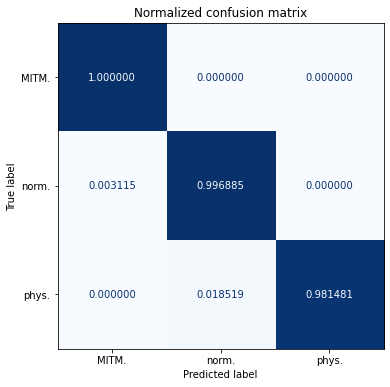

                precision    recall  f1-score   support

          MITM       0.99      1.00      1.00       109
        normal       1.00      1.00      1.00       321
physical fault       1.00      0.98      0.99        54

      accuracy                           1.00       484
     macro avg       1.00      0.99      0.99       484
  weighted avg       1.00      1.00      1.00       484


Metrics for class MITM:
True negative rate: 0.9973
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0027

Metrics for class normal:
True negative rate: 0.9939
True positive rate: 0.9969
False negative rate: 0.0031
False positive rate: 0.0061

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.9815
False negative rate: 0.0185
False positive rate: 0.0000


In [63]:
KNN_attack_detection(df_attack_1)

taille 2104


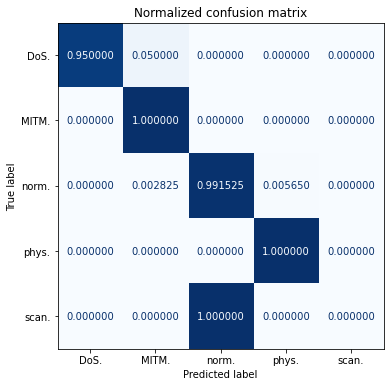

                precision    recall  f1-score   support

           DoS       1.00      0.95      0.97        20
          MITM       0.89      1.00      0.94        16
        normal       1.00      0.99      0.99       354
physical fault       0.94      1.00      0.97        30
          scan       0.00      0.00      0.00         1

      accuracy                           0.99       421
     macro avg       0.76      0.79      0.78       421
  weighted avg       0.99      0.99      0.99       421


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.9500
False negative rate: 0.0500
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9951
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0049

Metrics for class normal:
True negative rate: 0.9851
True positive rate: 0.9915
False negative rate: 0.0085
False positive rate: 0.0149

Metrics for class physical fault:
True negative rate: 0.9949
True positive rate: 1.000

/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
KNN_attack_detection(df_attack_2)

taille 1254


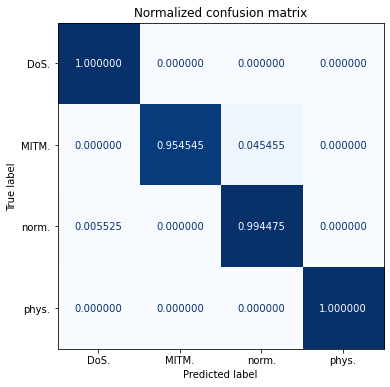

                precision    recall  f1-score   support

           DoS       0.92      1.00      0.96        12
          MITM       1.00      0.95      0.98        22
        normal       0.99      0.99      0.99       181
physical fault       1.00      1.00      1.00        36

      accuracy                           0.99       251
     macro avg       0.98      0.99      0.98       251
  weighted avg       0.99      0.99      0.99       251


Metrics for class DoS:
True negative rate: 0.9958
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0042

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9545
False negative rate: 0.0455
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9857
True positive rate: 0.9945
False negative rate: 0.0055
False positive rate: 0.0143

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.000

In [52]:
KNN_attack_detection(df_attack_3)

taille 1717


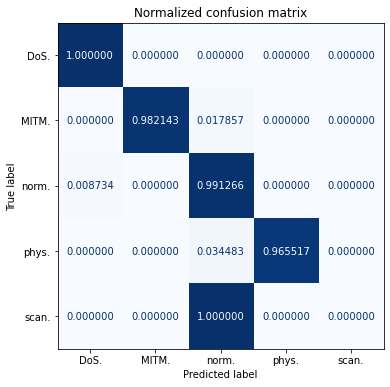

                precision    recall  f1-score   support

           DoS       0.94      1.00      0.97        29
          MITM       1.00      0.98      0.99        56
        normal       0.99      0.99      0.99       229
physical fault       1.00      0.97      0.98        29
          scan       0.00      0.00      0.00         1

      accuracy                           0.99       344
     macro avg       0.78      0.79      0.79       344
  weighted avg       0.98      0.99      0.98       344


Metrics for class DoS:
True negative rate: 0.9937
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0063

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9821
False negative rate: 0.0179
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9739
True positive rate: 0.9913
False negative rate: 0.0087
False positive rate: 0.0261

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.965

/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
KNN_attack_detection(df_attack_4)

taille 7495


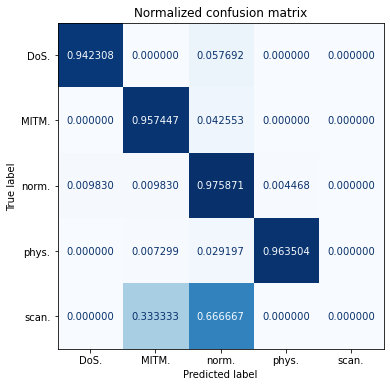

                precision    recall  f1-score   support

           DoS       0.82      0.94      0.87        52
          MITM       0.93      0.96      0.94       188
        normal       0.98      0.98      0.98      1119
physical fault       0.96      0.96      0.96       137
          scan       0.00      0.00      0.00         3

      accuracy                           0.97      1499
     macro avg       0.74      0.77      0.75      1499
  weighted avg       0.97      0.97      0.97      1499


Metrics for class DoS:
True negative rate: 0.9924
True positive rate: 0.9423
False negative rate: 0.0577
False positive rate: 0.0076

Metrics for class MITM:
True negative rate: 0.9901
True positive rate: 0.9574
False negative rate: 0.0426
False positive rate: 0.0099

Metrics for class normal:
True negative rate: 0.9553
True positive rate: 0.9759
False negative rate: 0.0241
False positive rate: 0.0447

Metrics for class physical fault:
True negative rate: 0.9963
True positive rate: 0.963

/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
KNN_attack_detection(pd.concat([df_attack_1,df_attack_2,df_attack_3,df_attack_4]))

taille 10923


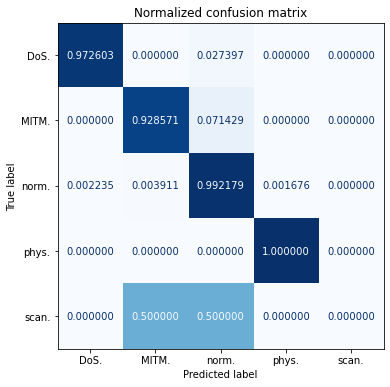

                precision    recall  f1-score   support

           DoS       0.95      0.97      0.96        73
          MITM       0.96      0.93      0.94       196
        normal       0.99      0.99      0.99      1790
physical fault       0.98      1.00      0.99       124
          scan       0.00      0.00      0.00         2

      accuracy                           0.99      2185
     macro avg       0.77      0.78      0.78      2185
  weighted avg       0.98      0.99      0.98      2185


Metrics for class DoS:
True negative rate: 0.9981
True positive rate: 0.9726
False negative rate: 0.0274
False positive rate: 0.0019

Metrics for class MITM:
True negative rate: 0.9960
True positive rate: 0.9286
False negative rate: 0.0714
False positive rate: 0.0040

Metrics for class normal:
True negative rate: 0.9570
True positive rate: 0.9922
False negative rate: 0.0078
False positive rate: 0.0430

Metrics for class physical fault:
True negative rate: 0.9985
True positive rate: 1.000

/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
KNN_attack_detection(pd.concat([df_normal,df_attack_1,df_attack_2,df_attack_3,df_attack_4]))

### 3 - Random Forest

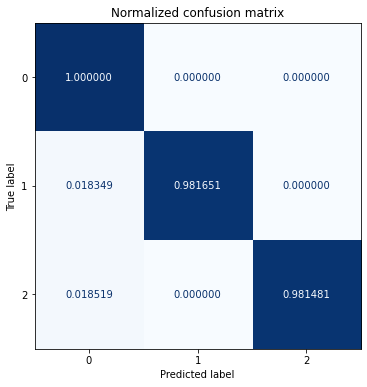

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       321
           1       1.00      0.98      0.99       109
           2       1.00      0.98      0.99        54

    accuracy                           0.99       484
   macro avg       1.00      0.99      0.99       484
weighted avg       0.99      0.99      0.99       484


Metrics for class 0:
True negative rate: 0.9816
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0184

Metrics for class 1:
True negative rate: 1.0000
True positive rate: 0.9817
False negative rate: 0.0183
False positive rate: 0.0000

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 0.9815
False negative rate: 0.0185
False positive rate: 0.0000


In [71]:
randomForest_attack_detector(df_attack_1)

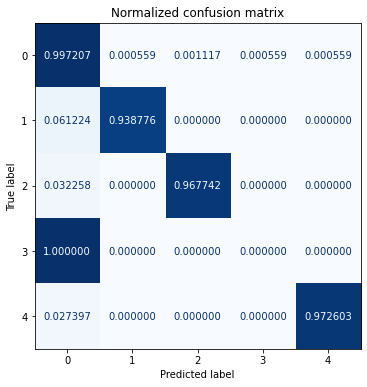

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1790
           1       0.99      0.94      0.97       196
           2       0.98      0.97      0.98       124
           3       0.00      0.00      0.00         2
           4       0.99      0.97      0.98        73

    accuracy                           0.99      2185
   macro avg       0.79      0.78      0.78      2185
weighted avg       0.99      0.99      0.99      2185


Metrics for class 0:
True negative rate: 0.9494
True positive rate: 0.9972
False negative rate: 0.0028
False positive rate: 0.0506

Metrics for class 1:
True negative rate: 0.9995
True positive rate: 0.9388
False negative rate: 0.0612
False positive rate: 0.0005

Metrics for class 2:
True negative rate: 0.9990
True positive rate: 0.9677
False negative rate: 0.0323
False positive rate: 0.0010

Metrics for class 3:
True negative rate: 0.9995
True positive rate: 0.0000
False negative rate: 1.0000
False posit

In [72]:
randomForest_attack_detector(pd.concat([df_normal,df_attack_1,df_attack_2,df_attack_3,df_attack_4]))

In [16]:
np.round([5.8,7,2.2])

array([6., 7., 2.])